In [1]:
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt

I don't understand why you need to run this command twice to get an interactive matplotlib display

In [2]:
%matplotlib ipympl

In [3]:
import lsst.daf.base               as dafBase
import lsst.daf.persistence        as dafPersist
import lsst.afw.display            as afwDisplay
import lsst.afw.table              as afwTable

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

#### Setup the displays (by default an interface to ds9 which won't work in the LSP)

In [4]:
afwDisplay.setDefaultBackend("matplotlib")

## Create the tasks

In [5]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()
if True:
    config.thresholdValue = 30       # detection threshold in units of thresholdType
    if True:
        print("SourceDetectionTask.thresholdType: %s" % (
              SourceDetectionTask.ConfigClass.thresholdType.__doc__))
    config.thresholdType = "stdev"   # units for thresholdValue
if False:                    
    config.doTempLocalBackground = True  # Use local-background during detection step
sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

SourceDetectionTask.thresholdType: specifies the desired flavor of Threshold (`str`, default ``'stdev'``)

Allowed values:

``'variance'``
  threshold applied to image variance
``'stdev'``
  threshold applied to image std deviation
``'value'``
  threshold applied to image value
``'pixel_stdev'``
  threshold applied to per-pixel std deviation



## Process the data

In [6]:
#butler = dafPersist.Butler("/Volumes/RHLData/hsc-v13_0")
butler = dafPersist.Butler("/datasets/hsc/repo/rerun/RC/w_2019_18/DM-19151")

In [7]:
if False:
    dataId = dict(tract=9348, patch='7,6', filter='HSC-I')
    exposure = butler.get('deepCoadd_calexp',dataId)
else:
    dataId = dict(visit=1232, ccd=50)
    exposure = butler.get('calexp', dataId)
    exposure.mask &= exposure.mask.getPlaneBitMask(["BAD", "CROSSTALK", "EDGE", "INTRP", "SAT"])  # clear other mask planes
    
tab = afwTable.SourceTable.make(schema)

result = charImageTask.run(exposure)

result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

if False:
    sourceDeblendTask.run(exposure, sources)

sourceMeasurementTask.run(sources, exposure)

if False:
    sources.writeFits("outputTable.fits")
    exposure.writeFits("example1-out.fits")

## Look at the results

In [8]:
sources = sources.copy(True)

good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

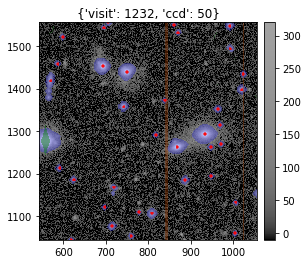

In [9]:
disp  = afwDisplay.Display(1, reopenPlot=True)
disp.scale('asinh', -10, 40)
disp.setMaskPlaneColor("CROSSTALK", afwDisplay.IGNORE)   # I don't care about crosstalk-corrected pixels
disp.mtv(exposure, title=dataId)
    
disp.pan(800, 1300); disp.zoom(8)

with disp.Buffering():
    for s in sources[good]:
        disp.dot('+', *s.getCentroid(), ctype=afwDisplay.RED)